# Only Parallel Data Model

This is the Python Notebook concerning the final version containing the coding for the Only-Parallel (Supervised) version of the program. It is to be completed with the correct format of the Contextual and Style Classifiers in their corresponding parts.

Date of upload: Friday 31th January

Actual Version: 3.0, coherence implemented (Monday 10th February, night)

Precedent Versions : 2.1, 2.0, 1.1, 1.0



## import(s)

In [1]:
from scripts.data_builders.prepare_dataset import prepare_dataset_parallel,string2code,code2string

import math
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torchnlp.metrics import get_moses_multi_bleu,get_token_accuracy
from torch.optim import Adam

from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device = ",device)
print(torch.__version__)

device =  cuda
1.4.0


## Data Pre-processing

In [2]:
train_data, dict_words = prepare_dataset_parallel("data/shakespeare.csv",device,ratio=0.5) #check with shift+tab to look at the data structure
batch_size = 1
dict_token = {b:a for a,b in dict_words.items()}

Loading ...
- Shakespeare dataset length :  21079
- Corrupted samples (ignored) :  0


## Parameters and Embedding

In [3]:
savepath = Path("data/models/embedding_v1")
embedding = torch.load(savepath,map_location = device)
embedding.weight.requires_grad = False

In [4]:
nb_heads = 4
d_feedforward = 1024
batch_size = 16
dict_size = len(dict_token)

d_embedding = embedding.embedding_dim

## Positional Encoding

In [5]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Context Classifier (To be filled)

In [6]:
savepath_style = Path("data/models/coherence_classifier_v1_epoch_100")
coherence_classifier = torch.load(savepath_style,map_location = device)
coherence_classifier.requires_grad = False

## Style classifier (To be filled)

In [7]:
savepath_style = Path("data/models/style_classifier_v1")
style_classifier = torch.load(savepath_style,map_location = device)
style_classifier.requires_grad = False

## Model (To be adapted once we have the Context and Style Class For the Embedding)

In [8]:
class ParallelModel(torch.nn.Module):
    def __init__(self,dict_size, d_embedding, nb_heads, d_feedforward):
        super().__init__()
       
        self.embed_layer = torch.nn.Embedding(dict_size+1, d_embedding, padding_idx=dict_size)
        self.positional_layer = PositionalEncoding(d_embedding)
        self.sentence_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads,
                                                    dim_feedforward = d_feedforward)
        self.context_encoder = torch.nn.TransformerEncoderLayer(d_model = d_embedding, nhead = nb_heads,
                                                    dim_feedforward = d_feedforward)
        self.sentence_decoder = torch.nn.TransformerDecoderLayer(d_model = d_embedding, nhead = nb_heads,
                                                    dim_feedforward = d_feedforward)
        self.label_embedding = torch.nn.Embedding(2,768)
        self.padd = dict_size
   
    def _generate_padding_mask(self,x):
        mask = (x == dict_size)
        return mask
   
    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
   
    def forward(self,x,ctx_x,y,label_x):
        device = x.device
        padd_x_mask = self._generate_padding_mask(x).to(device)
        padd_ctx_mask = self._generate_padding_mask(ctx_x).to(device)
        padd_y_mask = self._generate_padding_mask(y).to(device)
       
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
        mask_y = self._generate_square_subsequent_mask(y.shape[1]).to(device)
       
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
       
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
       
        # Encoders
        x_enc = self.sentence_encoder(x,src_mask=mask_x,src_key_padding_mask=padd_x_mask)
        ctx_enc = self.context_encoder(ctx_x,src_mask=mask_ctx,src_key_padding_mask=padd_ctx_mask)
 
        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1])).to(device)
        x_lab = x_and_ctx + self.label_embedding(label)
       
        # Decoder
        padd_mem_mask = torch.cat((padd_x_mask,padd_ctx_mask),1)
        y = self.embed_layer(y)
        y_pos = self.positional_layer(y.transpose(0,1))
        y_pred = self.sentence_decoder(y_pos,x_lab,tgt_mask=mask_y,tgt_key_padding_mask=padd_y_mask,
                                       memory_key_padding_mask=padd_mem_mask)
       
        return(y_pred.transpose(0,1),y)
   
    def translator(self,x,ctx_x,y,label_x):
        device = x.device
        mask_x = self._generate_square_subsequent_mask(x.shape[1]).to(device)
        mask_ctx = self._generate_square_subsequent_mask(ctx_x.shape[1]).to(device)
       
        # Embedding
        x = self.embed_layer(x).transpose(0,1) # token x batch x embedding
        ctx_x = self.embed_layer(ctx_x).transpose(0,1)
       
        # Positional Encoding
        x = self.positional_layer(x)
        ctx_x = self.positional_layer(ctx_x)        
       
        # Encoders
        x_enc = self.sentence_encoder(x,mask_x)
        ctx_enc = self.context_encoder(ctx_x,mask_ctx)
       
        # Linear and Style Mixing
        x_and_ctx = torch.cat((x_enc,ctx_enc),dim = 0)
        label = (1-label_x).reshape((1,x_and_ctx.shape[1])).expand((x_and_ctx.shape[0],x_and_ctx.shape[1]))
        x_lab = x_and_ctx + self.label_embedding(label)
        return(x_lab)

## Training  (To be adapted once we have the Context and Style Class For the Embedding)

In [9]:
# Definition of the model(s)

model = ParallelModel(dict_size, d_embedding, nb_heads, d_feedforward).to(device)
model.embed_layer = embedding
model.embed_layer.weight.requires_grad = False

In [10]:
# Information concerning the Training optimizer

decoder_linear = torch.nn.Linear(d_embedding,dict_size+1).to(device)
softmax_layer = torch.nn.LogSoftmax(dim = 2).to(device)

params = list(model.parameters()) + list(decoder_linear.parameters())#+ list(context_encoder.parameters()) + 
                                  #list(linear_context.parameters) + list(sentence_decoder.parameters())

l_r = 5e-2
optimizer=Adam(params,lr=l_r)

#Weights of the losses
l1=1 #
l2=1e-2
l3=1

In [11]:
# Losses 
#loss_seq2seq = torch.nn.SmoothL1Loss(reduction='mean') #Contextual Seq2Seq Loss
loss_seq2seq = torch.nn.KLDivLoss(reduction = 'mean')

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                            shuffle=True,collate_fn=train_data.collate)
for x,y, ctx_x, ctx_y_1,ctx_y_2, label_x in train_loader:
    print("x:")
    print(code2string(x[0],dict_token))
    print("y:")
    print(code2string(y[0],dict_token))
    print("ctx_x:")
    print(code2string(ctx_x[0],dict_token))
    print("ctx_y_1:")
    print(code2string(ctx_y_1[0],dict_token))
    print("ctx_y_2:")
    print(code2string(ctx_y_2[0],dict_token))
    print("label:")
    print(label_x)
    break

x:
<SOS> you know the law . <EOS>
y:
<SOS> you know the law . <EOS>
ctx_x:
<SOS> you seem like a good judge . i urge you to deliver your verdict . <EOS>
ctx_y_1:
<SOS> it doth appear you are a worthy judge .
ctx_y_2:
i charge you by the law , whereof you are a well-deserving pillar , proceed to judgment . <EOS>
label:
tensor([0])


In [22]:
nb_epoch = 1
writer = SummaryWriter("data/runs/parallel_model_v0")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True,collate_fn=train_data.collate)
n = len(train_data.x) // batch_size

for epoch in range(nb_epoch):
    total_loss = total_seq = total_style = total_coh = total_accuracy = total_BLEU = 0
    i = 0
    
    for x,y, ctx_x, ctx_y_1,ctx_y_2, label_x in train_loader:
        i += 1
        optimizer.zero_grad()
        
        y_pred,_ = model.forward(x,ctx_x,y,label_x) #Output still embedded
        y_dist = softmax_layer(decoder_linear(y_pred))
        
        # Seq2Seq Loss with Embedding
        y_hot = torch.nn.functional.one_hot(y).float()
        y_hot[y_hot==dict_size] = 0.
        
        loss_seq = loss_seq2seq(y_dist,y_hot)
        
        # Style Loss
        loss_sty,_ = style_classifier.forward(inputs_embeds=y_pred,attention_mask=(y != dict_size).int(),labels=(1-label_x).to(device))
        
        
        # Coherence Loss
        ctx_y = torch.cat([embedding(ctx_y_1),y_pred,embedding(ctx_y_2)],dim=1)
        mask_coh = torch.cat([(ctx_y_1 != dict_size).int(),
                              ((y != dict_size)*(y != 0)*(y != 1)).int(),
                              (ctx_y_2 != dict_size).int()],dim=1).to(device)
        loss_coh,_ = coherence_classifier(inputs_embeds=ctx_y,attention_mask=mask_coh,labels=torch.LongTensor([1]*batch_size).to(device))
        
        
        # Total Loss
        loss = l1 * loss_seq + l2 * loss_sty + l3 *  loss_coh

        # Step
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_seq += loss_seq.item()
        total_style += loss_sty.item()
        total_coh += loss_coh.item()
        
        pred = torch.argmax(y_dist,dim=2)
        hypotheses = [code2string(item,dict_token) for item in pred]
        references = [code2string(item,dict_token) for item in y]
        accuracy,_,_ = get_token_accuracy(y,pred)
        total_accuracy += accuracy
        BLEU = get_moses_multi_bleu(hypotheses,references)
        total_BLEU += BLEU

    #Vizualization and saving model
        print('| epoch {:3d} | {:5d}/{:5d} batches | '
              'total loss {:5.2f} | seq2seq loss {:5.2f} | '
              'style loss {:5.2f} | coherence loss {:5.2f}'
              '| total accuracy {:5.2f} | total BLEU {:5.2f}'.format(
                epoch+1, i, n,total_loss/i,total_seq/i,total_style/i,total_coh/i,total_accuracy/i,total_BLEU/i))
    print('-' * 110)
    writer.add_scalar('train_loss',total_loss/n,epoch+1)
    writer.add_scalar('train_loss_seq',total_seq/n,epoch+1)
    writer.add_scalar('train_loss_style',total_style/n,epoch+1)
    writer.add_scalar('train_loss_coh',total_coh/n,epoch+1)
    writer.add_scalar('train_word_accuracy',total_accuracy/n,epoch+1)
    writer.add_scalar('train_BLEU',total_BLEU/n,epoch+1)
    torch.save(model,"parallel_model_v0")

| epoch   1 |     1/ 1317 batches | total loss  0.48 | style loss  0.47 | seq2seq loss  0.01 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     2/ 1317 batches | total loss  0.49 | style loss  0.49 | seq2seq loss  0.01 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     3/ 1317 batches | total loss  0.50 | style loss  0.49 | seq2seq loss  0.02 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     4/ 1317 batches | total loss  0.47 | style loss  0.47 | seq2seq loss  0.02 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     5/ 1317 batches | total loss  0.45 | style loss  0.45 | seq2seq loss  0.03 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     6/ 1317 batches | total loss  0.44 | style loss  0.43 | seq2seq loss  0.03 | coherence loss  0.01| total accuracy  0.00 | total BLEU  0.00
| epoch   1 |     7/ 1317 batches | total loss  0.45 | sty

KeyboardInterrupt: 

In [24]:
hypotheses

['attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt attempt',
 'attempt walnut attempt attempt attempt attempt attempt attempt attempt attempt encamp attempt attempt encamp attempt walnut attempt attempt attempt walnut attempt attempt attempt attempt walnut attempt attempt attempt half-blood attempt attempt walnut attempt',
 'attempt attempt attempt attempt attempt attempt hopefully walnut attempt attempt walnut attempt attempt attempt attempt trainers half-blood walnut attempt attempt attempt attempt attempt attempt walnut walnut attempt attempt half-blood havoc walnut havoc attempt',
 "attempt attempt attempt attempt attempt attempt attempt attempt encamp attempt walnut attempt attempt attempt attempt attempt encamp attempt ma'am attempt attempt attempt recomforture attempt attempt

In [25]:
references

['<SOS> when we have matched our rackets to these balls , we will in france , by god’s grace , play a set shall strike his father’s crown into the hazard . <EOS>',
 '<SOS> what ? <EOS>',
 '<SOS> true , if a fool such as yourself could find it . <EOS>',
 '<SOS> ay , by heaven , my lord . <EOS>',
 '<SOS> speak to me home . <EOS>',
 '<SOS> lain . <EOS>',
 '<SOS> so , thanks to all at once and to each one , whom we invite to see us crowned at scone . <EOS>',
 '<SOS> wilt thou , strato ? <EOS>',
 '<SOS> looked he or red or pale , or sad or merrily ? <EOS>',
 '<SOS> for , meeting her of late behind the wood , seeking sweet favors from this hateful fool , i did upbraid her and fall out with her . <EOS>',
 '<SOS> the only thing different about me is my clothes . <EOS>',
 '<SOS> now forth , lord constable and princes all , and quickly bring us word of england’s fall . <EOS>',
 '<SOS> enough of your magic spells , you hateful , withered hag . <EOS>',
 '<SOS> and neigh , and bark , and grunt , an

In [58]:
torch.argmax(y_dist)

[tensor([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9, 11, 12, 13,  1],
        device='cuda:0'),
 tensor([ 0, 19, 20, 21, 22, 23, 24, 25, 24, 26, 27, 28, 24, 29, 30, 31, 32, 24,
         33, 34,  9, 27, 35, 29, 36, 13,  1], device='cuda:0'),
 tensor([ 0, 51, 24, 52, 40, 13,  1], device='cuda:0'),
 tensor([ 0, 53, 40, 54, 13,  1], device='cuda:0'),
 tensor([ 0, 29, 52, 26, 27, 28, 13,  1], device='cuda:0'),
 tensor([ 0,  9, 56, 57, 58, 59, 13,  1], device='cuda:0'),
 tensor([ 0, 28, 29, 62, 56, 63, 42, 64, 65, 13,  1], device='cuda:0'),
 tensor([ 0, 67, 68,  7, 69,  9,  5, 49, 59, 13,  1], device='cuda:0'),
 tensor([ 0, 19, 37, 24, 51,  2, 73, 74, 75, 76, 47, 19, 37, 13, 77, 78, 79, 75,
         80, 81, 82, 10, 77, 13,  1], device='cuda:0'),
 tensor([ 0, 87, 88, 89, 24, 19, 37, 90, 19, 37, 22, 74,  5, 91, 92,  7, 93, 94,
         95, 96, 97, 13,  1], device='cuda:0'),
 tensor([  0, 103,  24, 104, 105,  24, 106,  72,  79,  75, 107,  24, 108,  80,
          29, 109,  24, 110,  75, 111, 112

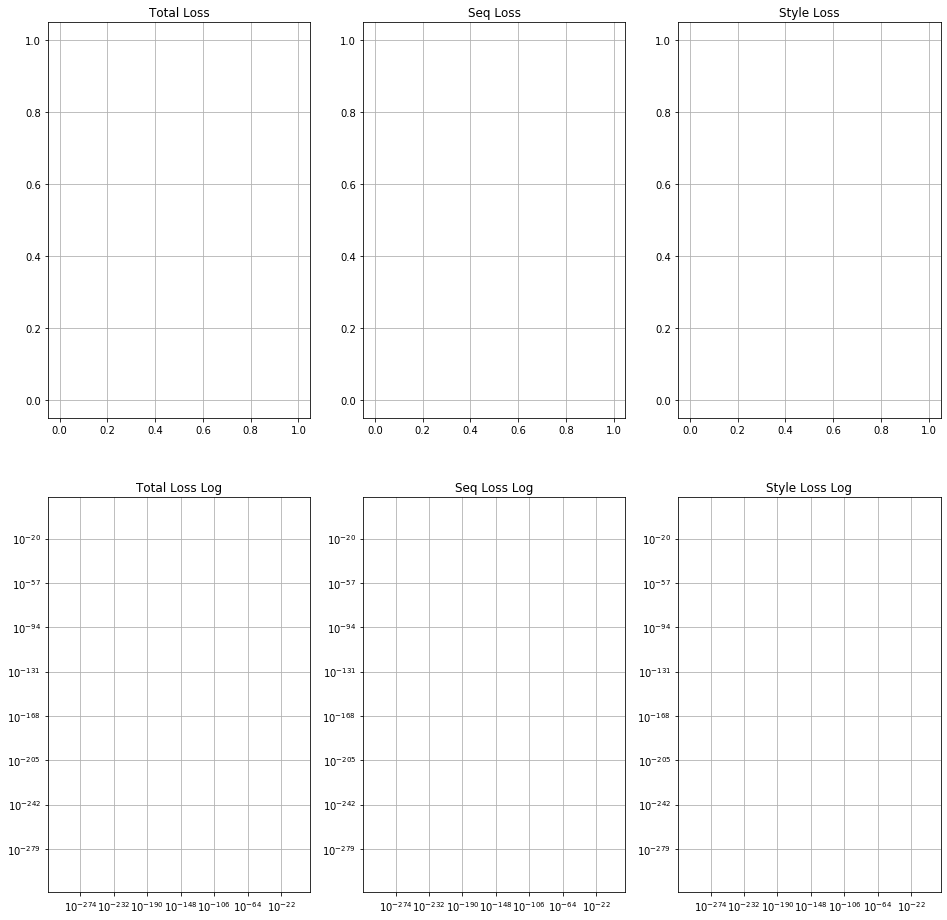

In [39]:
# reduction = 'sum' l_r = 5e-4
from matplotlib import pyplot as plt
import numpy as np
rango = np.arange(len(loss_graph))
plt.figure(1,figsize=(16,16))
plt.subplot(231)
plt.plot(rango,loss_graph)
plt.title("Total Loss")
plt.grid()
plt.subplot(234)
plt.plot(rango,loss_graph)
plt.xscale('log')
plt.yscale('log')
plt.title("Total Loss Log")
plt.grid()
plt.subplot(232)
plt.plot(rango,loss_seq_list)
plt.title("Seq Loss")
plt.grid()
plt.subplot(235)
plt.plot(rango,loss_seq_list)
plt.xscale('log')
plt.yscale('log')
plt.title("Seq Loss Log")
plt.grid()
plt.subplot(233)
plt.plot(rango,loss_style_list)
plt.title("Style Loss")
plt.grid()
plt.subplot(236)
plt.plot(rango,loss_style_list)
plt.title("Style Loss Log")
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [50]:
x,y,ctx_x,_,_,label_x,_ = train_data[0]
if(label_x == 1):
    print("Original Style : Shakespearian")
else:
    print("Original Style : Modern")
print("Original Phrase",code2string(x,dict_token))
print("Target phrase",code2string(y,dict_token))

Original Phrase I HAVE A MIND TO STRIKE THEE ERE
Target phrase I HAVE HALF A MIND TO HIT YOU BEFORE YOU SPEAK
Original Style : Shakespearian


torch.Size([1, 13])

In [116]:
    #Generation de phrase 
with torch.no_grad():
        h_t = model.translator(x.unsqueeze(0),ctx_x.unsqueeze(0),y.unsqueeze(0),torch.tensor([label_x]).unsqueeze(0))
        phrase = torch.tensor([[0]])
        print("Starting with: ",end='')
        for p in phrase:
            print(dict_token[p.item()],end=' ')
        print("")
        i = 0
        limit = 20
        flag = False
        while(not(flag) and i != limit):
            #mask = model._generate_square_subsequent_mask(phrase.shape[1])
            y_aux = model.embed_layer(phrase)
            y_pos = model.positional_layer(y_aux)
            y_pred = model.sentence_decoder(y_pos,h_t).transpose(0,1)
            y_pred = decoder_linear(y_pred)
            y_pred = torch.argmax(softmax_layer(y_pred),dim = 2)
            phrase = torch.cat((phrase,y_pred[:,-1].reshape((1,1))),0)
            i += 1
            flag = (y_pred[:,-1].item() == 1)
        print("Produced phrase: ",end='')
        for p in phrase:
            print(dict_token[p.item()],end=' ')
        print("")
            

Starting with: <SOS> 
torch.Size([1, 1])
tensor([15183])
Produced phrase: <SOS> AMPLE 
torch.Size([1, 2])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE 
torch.Size([1, 3])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE AMPLE 
torch.Size([1, 4])
tensor([15241])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY 
torch.Size([1, 5])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE 
torch.Size([1, 6])
tensor([15183])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE 
torch.Size([1, 7])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE 
torch.Size([1, 8])
tensor([10566])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE 
torch.Size([1, 9])
tensor([15241])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE BERKELEY 
torch.Size([1, 10])
tensor([64])
Produced phrase: <SOS> AMPLE AMPLE AMPLE BERKELEY DO-DE AMPLE DO-DE DO-DE BERKELEY THAN 
torch.Size([1, 11])
tensor([10566]